## <U> <center> Topic Modeling

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import nltk
nltk.download('stopwords')
import pandas as pd
import re
import math

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aditya.baser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing Dataset

In [2]:
import pandas as pd
df_tweets = pd.read_csv('words_data_combined_csv.csv')
df_tweets.head()

,Unnamed: 0,got_criteria,tweet_text,date,hashtags,link,username,to,replies,retweets,favorites,geo,mentions,id
0,0,<GetOldTweets3.models.Tweet.Tweet object at 0x...,"Few insurance companies like Allstate, Progres...",2020-04-30 23:26:38+00:00,NaN,https://twitter.com/chadha_mayur/status/125600...,chadha_mayur,Jaw709,0,0,1,NaN,NaN,1.256000e+18
1,1,<GetOldTweets3.models.Tweet.Tweet object at 0x...,"... I'm not a betting primate, however, if you...",2020-04-30 23:01:02+00:00,NaN,https://twitter.com/IMonkeyDesign/status/12559...,IMonkeyDesign,MCins_,1,0,0,NaN,NaN,1.256000e+18
2,2,<GetOldTweets3.models.Tweet.Tweet object at 0x...,If you are planning to build software to contr...,2020-04-30 22:07:55+00:00,NaN,https://twitter.com/alomour/status/12559822385...,alomour,alomour,1,0,0,NaN,NaN,1.255980e+18
3,3,<GetOldTweets3.models.Tweet.Tweet object at 0x...,"They grow up fast, so start planning for their...",2020-04-30 22:00:44+00:00,NaN,https://twitter.com/lewis_niky/status/12559804...,lewis_niky,NaN,0,0,0,NaN,NaN,1.255980e+18
4,4,<GetOldTweets3.models.Tweet.Tweet object at 0x...,NV is still planning a mid-May rollout for the...,2020-04-30 21:59:36+00:00,NaN,https://twitter.com/RileySnyder/status/1255980...,RileySnyder,TheNVIndy,0,3,6,NaN,@DETRJobConnect,1.255980e+18


In [6]:
df_tweets = df_tweets[["date","tweet_text"]]
df_tweets = df_tweets.dropna()
df_tweets

,date,tweet_text
0,2020-04-30 23:26:38+00:00,"Few insurance companies like Allstate, Progres..."
1,2020-04-30 23:01:02+00:00,"... I'm not a betting primate, however, if you..."
2,2020-04-30 22:07:55+00:00,If you are planning to build software to contr...
3,2020-04-30 22:00:44+00:00,"They grow up fast, so start planning for their..."
4,2020-04-30 21:59:36+00:00,NV is still planning a mid-May rollout for the...
...,...,...
31675,2019-05-01 20:24:30+00:00,Happy New Year!! Time for Resolutions… Time fo...
31676,2019-05-01 20:17:51+00:00,"Looking for health #insurance, car #insurance,..."
31677,2019-05-01 19:46:42+00:00,In 2018 the hits kept coming for high profile ...
31678,2019-05-01 19:15:05+00:00,Mmmm... sounds like a plan for 2020! Need to s...


## Tweet Preprocessing

In [9]:
def clean_tweets(df=df_tweets, 
                 tweet_col='tweet_text'
                ):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    # lower the tweets
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    # filter out stop words and URLs
    en_stop_words = stopwords.words('english')
    extended_words = ['insurance', 'planning', '#insurance', '#planning', 'car', 'may', 'get', 'amp']
    en_stop_words.extend(extended_words)
    en_stop_words = set(en_stop_words)
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in en_stop_words) and (not re.match(url_re, word))]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    
    return df_copy
  
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean.head()

,date,tweet_text,preprocessed_tweet_text,tokenized_tweet_text
0,2020-04-30 23:26:38+00:00,"Few insurance companies like Allstate, Progres...","companies like allstate, progressive already r...","[companies, like, allstate, progressive, alrea..."
1,2020-04-30 23:01:02+00:00,"... I'm not a betting primate, however, if you...","... i'm betting primate, however, offer motor ...","[betting, primate, however, offer, motor, curr..."
2,2020-04-30 22:07:55+00:00,If you are planning to build software to contr...,"build software control fraud, money laundry, s...","[build, software, control, fraud, money, laund..."
3,2020-04-30 22:00:44+00:00,"They grow up fast, so start planning for their...","grow fast, start future today dreamsecure chil...","[grow, fast, start, future, today, dreamsecure..."
4,2020-04-30 21:59:36+00:00,NV is still planning a mid-May rollout for the...,nv still mid-may rollout supplemental pua unem...,"[nv, still, mid, may, rollout, supplemental, p..."


In [10]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_tweet_text for word in tweet],10)

[('life', 7707),
 ('insurance', 7580),
 ('planning', 5101),
 ('financial', 4853),
 ('new', 3789),
 ('health', 3646),
 ('amp', 3395),
 ('coverage', 3387),
 ('learn', 3145),
 ('help', 3087)]

In [11]:
# build a dictionary where for each tweet, each word has its own id.
# We have 6882 tweets and 10893 words in the dictionary.
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_tweet_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_tweet_text]

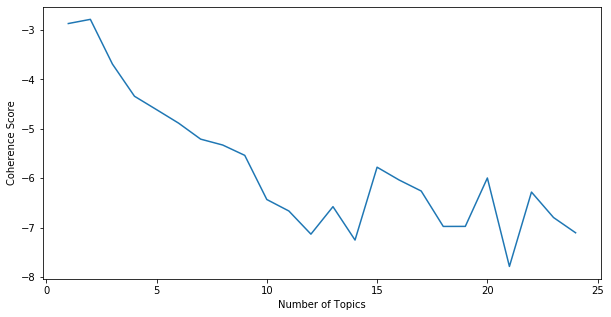

In [12]:
# compute coherence
tweets_coherence = []
for nb_topics in range(1,25):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,25),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

In [12]:
k = 18
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

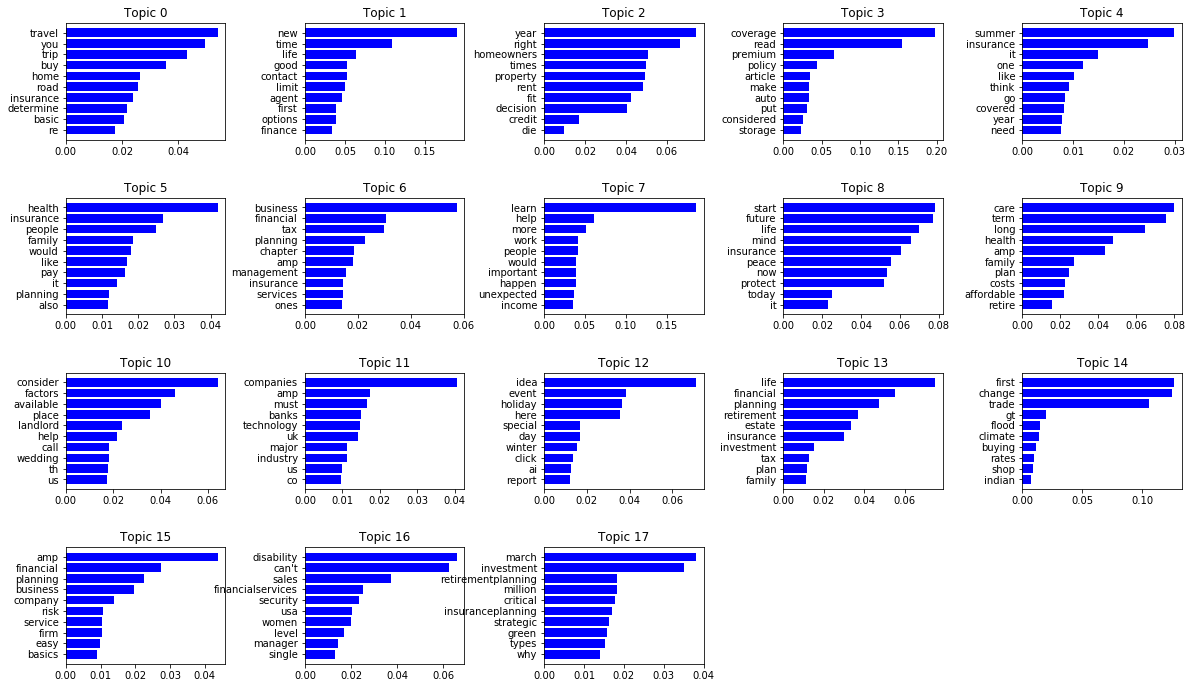

In [13]:
import matplotlib.gridspec as gridspec
plot_top_words()

In [14]:
list1 = []
list2 = []
for i in range(len(df_tweets_clean)):
    x = tweets_lda[tweets_corpus[i]]
    x.sort(key=lambda x:x[1], reverse = True)
    list1.append('Topic'+str(x[0][0]))
    try:
        if x[1][1] > 0.3:
            list2.append('Topic'+str(x[1][0]))
        else: 
            list2.append(None)
    except: 
            list2.append(None)

In [15]:
print(len(list1),len(list2))

31680 31680


In [16]:
df_tweets_clean["Label1"] = list1
df_tweets_clean["Label2"] = list2
df_tweets_clean

,date,tweet_text,preprocessed_tweet_text,tokenized_tweet_text,Label1,Label2
0,2020-04-30 23:26:38+00:00,"Few insurance companies like Allstate, Progres...","companies like allstate, progressive already r...","[companies, like, allstate, progressive, alrea...",Topic11,None
1,2020-04-30 23:01:02+00:00,"... I'm not a betting primate, however, if you...","... i'm betting primate, however, offer motor ...","[betting, primate, however, offer, motor, curr...",Topic0,None
2,2020-04-30 22:07:55+00:00,If you are planning to build software to contr...,"build software control fraud, money laundry, s...","[build, software, control, fraud, money, laund...",Topic15,None
3,2020-04-30 22:00:44+00:00,"They grow up fast, so start planning for their...","grow fast, start future today dreamsecure chil...","[grow, fast, start, future, today, dreamsecure...",Topic8,None
4,2020-04-30 21:59:36+00:00,NV is still planning a mid-May rollout for the...,nv still mid-may rollout supplemental pua unem...,"[nv, still, mid, may, rollout, supplemental, p...",Topic11,None
...,...,...,...,...,...,...
31675,2019-05-01 20:24:30+00:00,Happy New Year!! Time for Resolutions… Time fo...,happy new year!! time resolutions… time financ...,"[happy, new, year, time, resolutions, time, fi...",Topic13,None
31676,2019-05-01 20:17:51+00:00,"Looking for health #insurance, car #insurance,...","looking health #insurance, #insurance, #child ...","[looking, health, insurance, insurance, child,...",Topic13,None
31677,2019-05-01 19:46:42+00:00,In 2018 the hits kept coming for high profile ...,2018 hits kept coming high profile data breach...,"[hits, kept, coming, high, profile, data, brea...",Topic10,None
31678,2019-05-01 19:15:05+00:00,Mmmm... sounds like a plan for 2020! Need to s...,mmmm... sounds like plan 2020! need start savi...,"[mmmm, sounds, like, plan, need, start, saving...",Topic13,None
